# Bicycle Collisions in California


### Data 

[**California Traffic Collisions from SWITRS**](https://www.kaggle.com/alexgude/california-traffic-collision-data-from-switrs) from the California Highway Patrol, covering collisions from January 1st, 2001 until mid-October, 2020.

Article: [Introducing the SWITRS SQLite Hosted Dataset](https://alexgude.com/blog/switrs-sqlite-hosted-dataset/)

### Introduction
Bicycles as a transport means have grown exponentially in the recent years with the redistribution of street space especially in major cities in Europe and North America (Arancibia et al, 2019; Koch and Kraus, 2020, Urra, 2020). While bicycling is an advantageous sustainable transport option for the people and evironment, safety remains a major concern (Deloitte, 2020; Saad et al, 2019). This notebook attempts to explore bicycle collisions in California with the  _collision_ and _parties_ tables.

### Part 1
* Bicycles collisions over time
* Which is the most common bicycle collision time? 
* Are bicycles more common on weekdays or weekends? 
* How weather conditions impact the severity of bicycle collisions?
* How road conditions impact the severity of bicycle collisions? 

Reference notebooks:
* [Starter: California Traffic Collisions from SWITRS](https://www.kaggle.com/alexgude/starter-california-traffic-collisions-from-switrs) 
* [Analysis of Motorcycle Crashes](https://www.kaggle.com/sstewart0/statistical-analysis/comments) 

### Part 2
* Using Fague SQL to explore data
    + Location type of bicycle collisions 
    + Severity of bicycle collisions 
    + Bicycle collisions: type of collision
    + Road surface type of bicycle collisions
    + Number of parties involved in bicycle collisions

Reference notebook:
* [California Traffic Collisions, Fugue SQL, part 1](https://www.kaggle.com/goodwanghan/california-traffic-collisions-fugue-sql-part-1) 



In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns
!pip install bioinfokit
from bioinfokit.analys import stat, get_data

pd.set_option('display.max_rows', 1500)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)


In [9]:
for dirname, _, filenames in os.walk('/users/lo/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/users/lo/kaggle/input/switrs.sqlite


## Bicycle collisions over time
Reference notebook: [Starter: California Traffic Collisions from SWITRS](https://www.kaggle.com/alexgude/starter-california-traffic-collisions-from-switrs)

In [22]:
# read sqlite query results into a pandas DataFrame
with sqlite3.connect("/users/lo/kaggle/input/switrs.sqlite") as con:
    query = (
        "SELECT collision_date "
        "FROM collisions "
        "WHERE collision_date IS NOT NULL AND bicycle_collision==1"
    )

    # construct a Dataframe from the results
    df = pd.read_sql_query(query, con, parse_dates=["collision_date"])

In [23]:
df.head()

,collision_date
0,2008-01-02
1,2008-01-02
2,2008-01-03
3,2008-01-01
4,2008-01-05


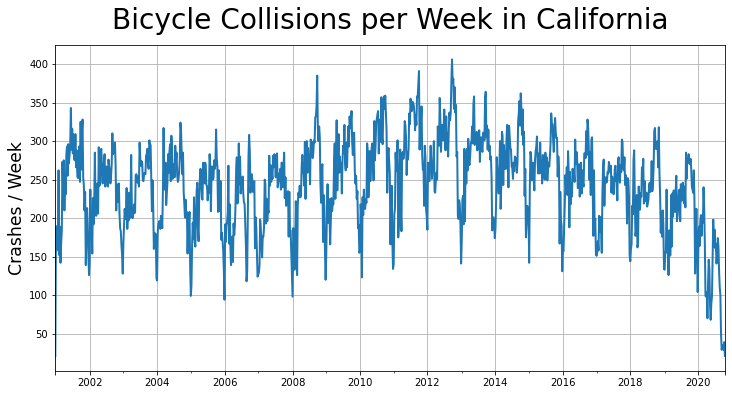

In [25]:
DATE_COL = "collision_date"

# convert to a timeseries
ts = df[[DATE_COL]]
ts.index= ts[DATE_COL]
ax = ts.resample('W-MON').count()[DATE_COL].plot(
    kind="line",
    title='Crashes in California',
    figsize=(12,6),
    linewidth=2,
)

# set Y range and grid
ax.grid()

# set axis labels
plt.title('Bicycle Collisions per Week in California', y=1.03, size=28)
FONTSIZE="xx-large"
plt.xlabel("")
plt.ylabel("Crashes / Week", fontsize=FONTSIZE)

plt.show()

## Bicycle collisions
Reference notebook: [Analysis of Motorcycle Crashes](https://www.kaggle.com/sstewart0/statistical-analysis/comments)

In [7]:
# SQL connection
con = sqlite3.connect("/users/lo/kaggle/input/switrs.sqlite")

cur = con.cursor()

In [8]:
parties_query = " SELECT * FROM parties WHERE case_id IN \
(SELECT case_id FROM collisions WHERE bicycle_collision == 1)"

victims_query = " SELECT * FROM victims WHERE case_id IN \
(SELECT case_id FROM collisions WHERE bicycle_collision == 1)"

In [9]:
# read the data
collisions1 = pd.read_sql_query("SELECT * FROM collisions WHERE bicycle_collision == 1", con)
parties1 = pd.read_sql_query(parties_query, con)
victims1 = pd.read_sql_query(victims_query, con)

# save the data as csv files
collisions1.to_csv('collisions.csv',index=False)
parties1.to_csv('parties.csv',index=False)
victims1.to_csv('victims.csv',index=False)

con.close()

In [11]:
collisions = pd.read_csv('collisions.csv',dtype=str)
parties = pd.read_csv('parties.csv',dtype=str)
victims = pd.read_csv('victims.csv',dtype=str)

In [12]:
# number of bicycle collisions
print("The number of unique case_ids is {n}".format(n=len(parties['case_id'].unique())))

The number of unique case_ids is 252023


In [13]:
# number of records in data 
print("{x} records in collisions.".format(x=collisions.shape[0]))
print("{y} records in parties.".format(y=parties.shape[0]))
print("{z} records in victims.".format(z=victims.shape[0]))

252023 records in collisions.
493572 records in parties.
285694 records in victims.


### Most common bicycle collision time 

In [14]:
#string to time
collisions['collision_time'] = pd.to_timedelta(collisions['collision_time'])
#1 hour slots
times = collisions.groupby(
    pd.Grouper(key='collision_time',freq='60Min',label='right')).agg(
    {'case_id':'count'}).reset_index()

sorted_times = times.sort_values(by='case_id',ascending=False)
sorted_times.head(10)

,collision_time,case_id
17,17:00:00,23734
15,15:00:00,22789
16,16:00:00,21739
18,18:00:00,20366
14,14:00:00,18228
7,07:00:00,15497
13,13:00:00,15197
12,12:00:00,14746
19,19:00:00,14068
8,08:00:00,13901


### Are bicycle collisions more common on weekdays or weekends?

In [15]:
#change datatypes
collisions.case_id = collisions.case_id.astype(np.float)
collisions.collision_date = pd.to_datetime(collisions.collision_date,format='%Y-%m-%d')
#new feature, where 1 = weekday and 0 = weekend
day_type = np.array([1 if x.weekday() < 5 else 0 for x in collisions['collision_date']])
#add feature to dataframe
collisions['day_type'] = day_type

In [16]:
#group by weekend/weekday & times
t = pd.Grouper(key='collision_time',freq='60Min') #time grouper
grouped_df = collisions.groupby([t, 'day_type']).agg({'case_id':'count'}).reset_index()

#how many weekdays & weekends?
no_weekdays = sum(1 for _ in collisions.loc[collisions['day_type'] == 1]['day_type'])
no_weekends = sum(1 for _ in collisions.loc[collisions['day_type'] == 0]['day_type'])

# get number of accidents on weekdays & weekends as a fraction of the total number of weekdays & weekends respectively
fracs = np.array(
    [x[2]/no_weekdays if x[1] == 1
     else x[2]/no_weekends
     for i,x in grouped_df.iterrows()
     ]
)

# Add to dataframe and sort 
grouped_df['frac'] = fracs
sorted_grouped = grouped_df.sort_values(by='frac',ascending=False)
sorted_grouped.head(10)

,collision_time,day_type,case_id,frac
35,17:00:00,1,19466,0.099603
31,15:00:00,1,18309,0.093683
33,16:00:00,1,17328,0.088663
37,18:00:00,1,16334,0.083577
30,15:00:00,0,4480,0.079170
32,16:00:00,0,4411,0.077951
24,12:00:00,0,4401,0.077774
26,13:00:00,0,4324,0.076413
28,14:00:00,0,4323,0.076396
34,17:00:00,0,4268,0.075424


### Probablity of bicycle collisions on weekdays versus weekends

In [17]:
# pwgc = P(weekend|crash)
pwgc = no_weekends/(no_weekdays + no_weekends)
# pw = P(weekend)
pw = 2/7

# pcgw = P(crash|weekend)
pcgw = pwgc/pw
# pcgwd = P(crash|weekday)
pcgwd = (1-pwgc)/(1-pw)

print("P(crash|weekend) = {x}.P(crash)".format(x=pcgw))
print("P(crash|weekday) = {x}.P(crash)".format(x=pcgwd))

P(crash|weekend) = 0.7858588303448495.P(crash)
P(crash|weekday) = 1.0856564678620602.P(crash)


The probablity of bicycle collisions is higher on a weekday than weekend. 

### Most common weather condition in bicycle collisions

In [18]:
# Weather input
w = ['weather_1','weather_2']
collisions[w] = collisions[w].replace(np.nan, '-',regex=True)

# Create list of tuples of weather:
weather = list(zip(collisions['weather_1'],collisions['weather_2']))
collisions['weather'] = weather

gb = 'weather'
collisions[gb] = collisions[gb].astype(str)

# Group by weather and sort by most popular
conditions_grouped = collisions.groupby([gb]).agg(
    {'case_id':'count'}
).reset_index()

conditions_grouped.sort_values(by='case_id',ascending=False)

,weather,case_id
1,"('clear', '-')",221027
8,"('cloudy', '-')",21839
19,"('raining', '-')",3602
0,"('-', '-')",1768
11,"('cloudy', 'raining')",1427
2,"('clear', 'cloudy')",556
14,"('fog', '-')",478
7,"('clear', 'wind')",465
17,"('other', '-')",271
4,"('clear', 'other')",137


### Plot function

In [19]:
def plot_condition(data, conditions, variable):
    # Replace nan by '-'
    nans = conditions
    data[nans] = data[nans].replace(np.nan, '-',regex=True)

    n = len(conditions)

    fig, axs = plt.subplots(ncols=len(conditions), sharey=True)
    
    fig.set_figheight(8)
    fig.set_figwidth(8)
    
    # Plot each condition seperately
    for i, cond in enumerate(conditions):
        grouped = data.groupby(cond)
        agg_grouped = grouped.agg({'killed_victims':'mean',
                                   'injured_victims':'mean',
                                   'motorcyclist_injured_count':'mean',
                                   'motorcyclist_killed_count':'mean',
                                   'party_count':'mean',
                                   'case_id':'count'}).reset_index()

        # Use Log-scale to 'compress' scale
        x = np.log(agg_grouped['case_id'])
        y = np.log(agg_grouped[variable])

        color_labels = agg_grouped[cond].unique()

        # List of colors in the color palettes
        rgb_values = sns.color_palette("Set2", len(color_labels))

        # Map weather to the colors
        color_map = dict(zip(color_labels, rgb_values))
        
        # Plot the points w/labels
        if n != 1:
            axs[i].scatter(x, y,c=agg_grouped[cond].map(color_map))

            for j, txt in enumerate(agg_grouped[cond]):
                axs[i].annotate(txt, (x[j], y[j]))

            axs[i].set_ylabel('(Log-scale) {X}'.format(X=variable.replace('_',' ')))

            axs[i].set_xlabel("(Log-scale) Count")
        else:
            axs.scatter(x, y, c=agg_grouped[cond].map(color_map))

            for j, txt in enumerate(agg_grouped[cond]):
                axs.annotate(txt, (x[j], y[j]))

            axs.set_ylabel('(Log-scale) {X}'.format(X=variable.replace('_', ' ')))

            axs.set_xlabel("(Log-scale) Count")

    plt.suptitle(' & '.join(c for c in conditions))
    plt.show()
    return None

### Fatality of bicycle collisions under weather conditions

/Users/lo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/lo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


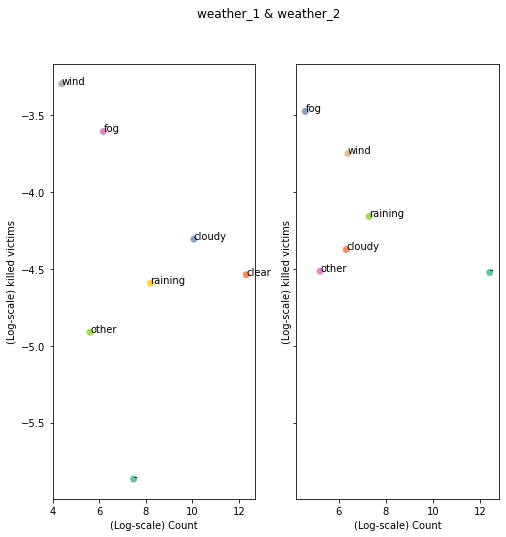

In [20]:
collisions1 = pd.read_csv('collisions.csv')
#fatality by weather_1 and weather_2
plot_condition(collisions1, ['weather_1','weather_2'], 'killed_victims')

Fog and wind weather conditions have the highest fatality rate in bicycle collisions. 

### P(Crash|Condition)

In [21]:
nans = ['weather_1','weather_2']
collisions[nans] = collisions[nans].replace('-', np.nan,regex=True)

# Get months
months = np.array([m.month for m in collisions['collision_date']])
collisions['month'] = months

# Group collisions by month and weather
gb_month_weather1 = collisions.groupby(['month','weather_1'])
agg_month_weather1 = gb_month_weather1.agg({'case_id':'count'}).reset_index()

gb_month_weather2 = collisions.groupby(['month','weather_2'])
agg_month_weather2 = gb_month_weather2.agg({'case_id':'count'}).reset_index()

# Create pivot tables of the above grouped dataframe
p_table1 = agg_month_weather1.pivot_table(index='month',
                                          columns='weather_1',
                                          values='case_id')

p_table2 = agg_month_weather2.pivot_table(index='month',
                                          columns='weather_2',
                                          values='case_id')

# Replace NaN's with 0
p_table1 = p_table1.replace(np.nan,0)
p_table2 = p_table2.replace(np.nan,0)

# Combine the results from both pivot tables, i.e. combine weather_1 & weather_2 results
p_table1[p_table2.columns] = p_table2[p_table2.columns]+p_table1[p_table2.columns]

# Sum(counts of each weather type) across each month
p_table1['sum'] = p_table1.sum(axis=1)

#P(condition|month) = p_condition_given_month
p_condition_given_month = p_table1.iloc[:,0:7].div(p_table1["sum"], axis=0)
# All unique weathers
weathers = p_condition_given_month.columns

# p(condition_i) = sum_j(P(condition_i|month_j).P(month_j)) = 1/12 * sum_j(P(condition_i|month_j))
p_condition = 1/12 * p_condition_given_month.sum(axis=0)

# Get P(crash n condition_i) for each i:
gb_weather1 = collisions.groupby(['weather_1']).agg({'case_id':'count'}).reset_index()
gb_weather2 = collisions.groupby(['weather_2']).agg({'case_id':'count'}).reset_index()

# Combine weather_1 & weather_2 totals
for i,b in gb_weather2.iterrows():
    gb_weather1.at[i+1, 'case_id'] += b[1]
    
# Total
total = gb_weather1['case_id'].sum()

# P(condition|crash) = 
p_condition_given_crash = gb_weather1['case_id'] / total

# P(crash|condition_i) = P(condition_i|crash) * P(crash) / P(condition_i)
p_crash_given_cond = np.array([x / p_condition[i] for i,x in enumerate(p_condition_given_crash)])

# P(crash|condition_i) as DF
p_cr_g_co = pd.DataFrame(list(zip(weathers,
                                  p_crash_given_cond,
                                  p_condition)))
p_cr_g_co.columns = ['Condition', 'P(Crash|Condition)/P(Crash)','P(Condition)']

p_cr_g_co = p_cr_g_co.sort_values(by='P(Crash|Condition)/P(Crash)',ascending=False)

p_cr_g_co

,Condition,P(Crash|Condition)/P(Crash),P(Condition)
0,clear,1.008505,0.870482
3,other,1.006637,0.001785
5,snowing,0.965944,0.000213
1,cloudy,0.955693,0.099271
6,wind,0.952768,0.002802
2,fog,0.922000,0.002480
4,raining,0.883143,0.022966


87% of the bicycle collisions in California occurs in clear weather condition.

### 𝑃((crash∩fatal)|condition𝑖)
Are certain weather conditions more fatal than others?

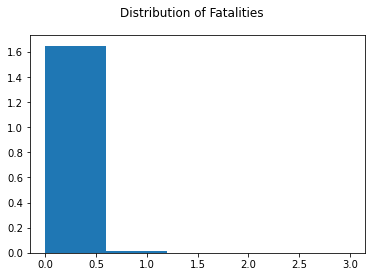

In [22]:
# 𝑃((fatal|crash))
#assess distribution of fatalities and best fit line

collisions['killed_victims'] = collisions['killed_victims'].astype(np.float)
collisions['killed_victims'] = collisions['killed_victims'].replace(np.nan,0)

plt.hist(collisions['killed_victims'],bins=5,density=True)
plt.suptitle("Distribution of Fatalities")
plt.show()

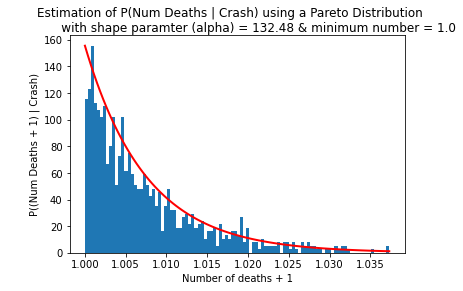

In [23]:
#probability of a observing a number deaths given that there has been a motorcycle crash
#without weather conditions

# Total sample size
n = len(collisions)

# Denominator of alpha_MLE
sum_ln_x = sum(np.log(x+1) for x in collisions['killed_victims'])

# Shape parameter
alpha = round(n/sum_ln_x,2)

# m = minimum possible value
a, m = alpha, 1.  # shape and mode

# Simulate 1000 results from this distributin
s = (np.random.pareto(a, 1000) + 1) * m

# Plot the estimated distribution
fig, ax = plt.subplots()

count, bins, _ = ax.hist(s, 100, density=True)
fit = a*m**a / bins**(a+1)

ax.plot(bins, max(count)*fit/max(fit), linewidth=2, color='r')
ax.set_xlabel('Number of deaths + 1')
ax.set_ylabel('P((Num Deaths + 1) | Crash)')

plt.suptitle('Estimation of P(Num Deaths | Crash) using a Pareto Distribution \n \
             with shape paramter (alpha) = {a} & minimum number = {m}'.format(
    a=alpha,m=m))

plt.show()

In [24]:
#Probablity with weather conditions

# Remove snow
p_condition_given_month = p_condition_given_month.drop('snowing',axis=1)
p_condition = 1/12 * p_condition_given_month.sum(axis=0)

# All weathers 
weathers = p_condition_given_month.columns

collisions_with_deaths = collisions[collisions.killed_victims > 0]

gb_weather1 = collisions_with_deaths.groupby(['weather_1']).agg({'case_id':'count'}).reset_index()
gb_weather2 = collisions_with_deaths.groupby(['weather_2']).agg({'case_id':'count'}).reset_index()

# Combine weather_1 & weather_2 totals
for i,b in gb_weather2.iterrows():
    gb_weather1.at[i+1, 'case_id'] += b[1]

# Total
total = gb_weather1['case_id'].sum()

# P(condition|crash&death) =
p_condition_given_crash = gb_weather1['case_id'] / total

# P(crash&death|condition_i) = P(condition_i|crash&death) * P(crash&death) / P(condition_i)
p_crash_given_cond = np.array([x / p_condition[i] for i,x in enumerate(p_condition_given_crash)])

# P(crash&death|condition_i) as DF
p_cr_g_co = pd.DataFrame(list(zip(weathers,
                                  p_crash_given_cond,
                                  p_condition)))
p_cr_g_co.columns = ['Condition',
                     'P((Crash & Fatality)|Condition)/P(Crash & Fatality)',
                     'P(Condition)']

p_cr_g_co = p_cr_g_co.sort_values(by='P((Crash & Fatality)|Condition)/P(Crash & Fatality)',
                                  ascending=False)

p_cr_g_co

,Condition,P((Crash & Fatality)|Condition)/P(Crash & Fatality),P(Condition)
2,fog,2.320294,0.002480
5,wind,2.182027,0.002802
1,cloudy,1.152289,0.099271
0,clear,0.977297,0.870482
4,raining,0.939751,0.022966
3,other,0.805921,0.001785


Fatalities in a bicycle collision are 134% more likely to occur in fog weather condition than in clear conditions

### Road conditions
Which are the most common road conditions in bicycle collisions?

/Users/lo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


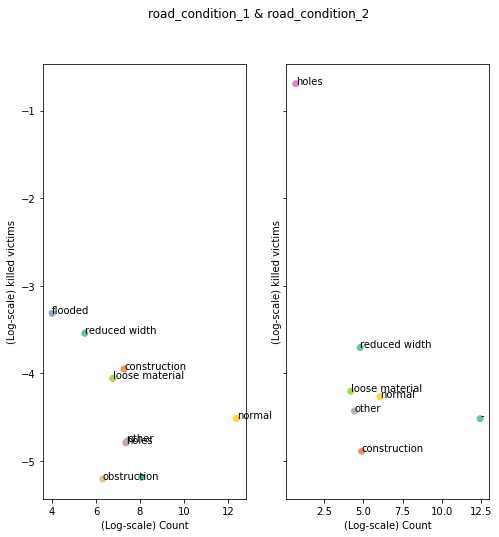

In [25]:
plot_condition(collisions1, ['road_condition_1','road_condition_2'], 'killed_victims')

Holes, flooded and reduced width road conditions have highest average fatalities in bicycle collisions.

### Part 1 Inferences

**Bicycle collisions in California**:
* The probablity of bicycle collisions is higher on a weekday than weekend in California. 
* 87% of the bicycle collisions in California occurs in clear weather condition.
* Fog and wind weather conditions have the highest fatality rate in bicycle collisions. 
    + Fatalities in a bicycle collision are 134% more likely to occur in fog weather condition than in clear conditions
* Road conditions: holes, flooded and reduced width have the highest average fatalities in bicycle collisions.


**Comparing bicycle collisions to [motorcycle collisions](https://www.kaggle.com/sstewart0/statistical-analysis)**:
* The probablity of bicycle collisions is higher on weekdays while motocycle collisions are higher on weekends. 
* As expected, majority of bicycle and motocycle collisions in California happened in clear weather 
* In both type of vehicle collisions, fog and wind weather have the highest fatality rate
* The largest impact on bicycle collisions fatality is holes and for motocycle collisions is obstruction, while reduced width has a significant impact on boht type of vehicle collisions. 


## Part 2

In [1]:
!pip install fuggle>=0.0.9

In [2]:
from fuggle import setup, Plot, PlotBar, PlotBarH, PlotLine
setup("native", {"fuggle.sqlite.path":"/users/lo/kaggle/input/"})

NativeExecutionEngine is set as backend


<IPython.core.display.Javascript object>

### Location types of bicycle collisions

In [3]:
%%fsql
SELECT location_type, COUNT(DISTINCT case_id) AS ct 
    FROM switrs.sqlite.collisions 
    WHERE bicycle_collision
    GROUP BY location_type
PRINT ROWS 100

,location_type,ct
0,None,233248
1,highway,7936
2,intersection,5928
3,ramp,4911


10.845338 seconds


* Majority of the bicycle collisions did specify a location type
* There are more bicycle collisions on the highway compared to intersection and ramp 

### Severity of bicycle collisions

9.863266 seconds


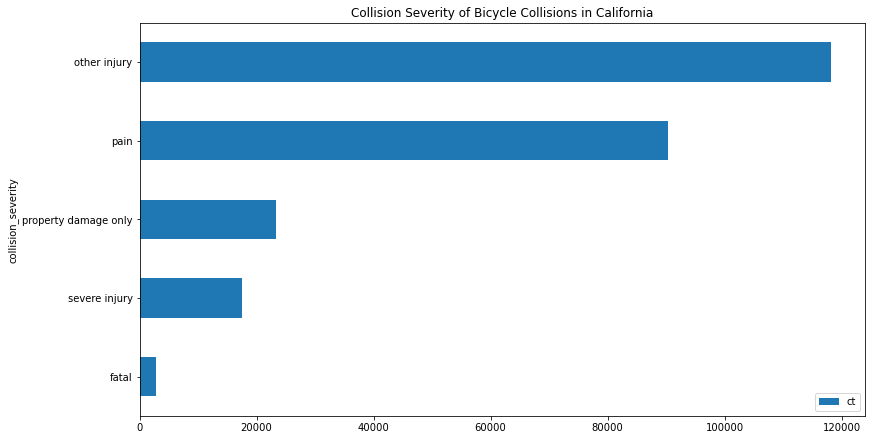

In [4]:
%%fsql
SELECT collision_severity, COUNT(DISTINCT case_id) AS ct 
    FROM switrs.sqlite.collisions 
    WHERE bicycle_collision
    GROUP BY collision_severity
OUTPUT USING PlotBarH(x="collision_severity", order_by=["ct"], title="Collision Severity of Bicycle Collisions in California")

* Majority of the bicycle collisions resulted in 'other injury' and pain.  

### Bicycle collision: type of collision

9.828367 seconds


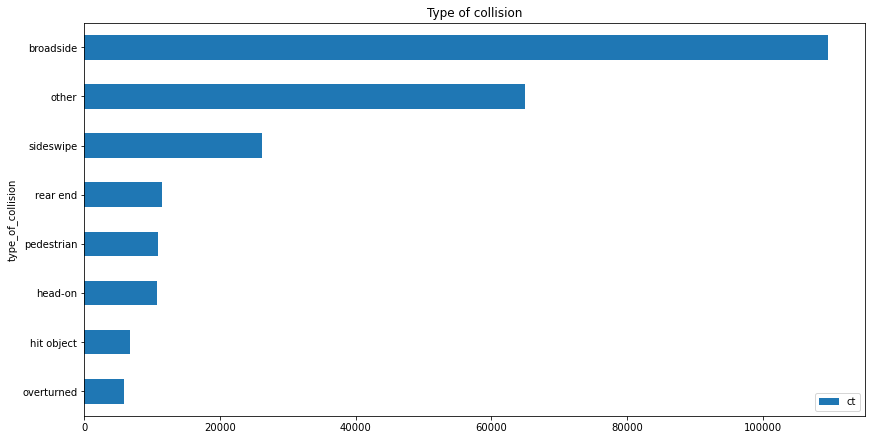

In [5]:
%%fsql
SELECT type_of_collision, COUNT(DISTINCT case_id) AS ct 
    FROM switrs.sqlite.collisions 
    WHERE bicycle_collision
    GROUP BY type_of_collision
OUTPUT USING PlotBarH(x="type_of_collision", order_by=["ct"], title="Type of collision")

* Broadside and sidewipe are the most common type of collision involving bicycles

### Road surface types of bicycle collisions 

In [6]:
%%fsql
SELECT road_surface, COUNT(DISTINCT case_id) AS ct 
    FROM switrs.sqlite.collisions 
    WHERE bicycle_collision
    GROUP BY road_surface
PRINT ROWS 100

,road_surface,ct
0,None,2947
1,H,3
2,dry,240253
3,slippery,229
4,snowy,91
5,wet,8500


10.661458 seconds


* Majority of the bicycle collisions in California occurred on dry road surface, followed by wet road surface. 

###  Number of parties involved in bicycle collisions

,number_of_parties,ct
0,1,17793
1,2,227854
2,3,5712
3,4,493
4,5,111
5,6,32
6,7,19
7,8,3
8,9,2
9,10,2


97.846448 seconds


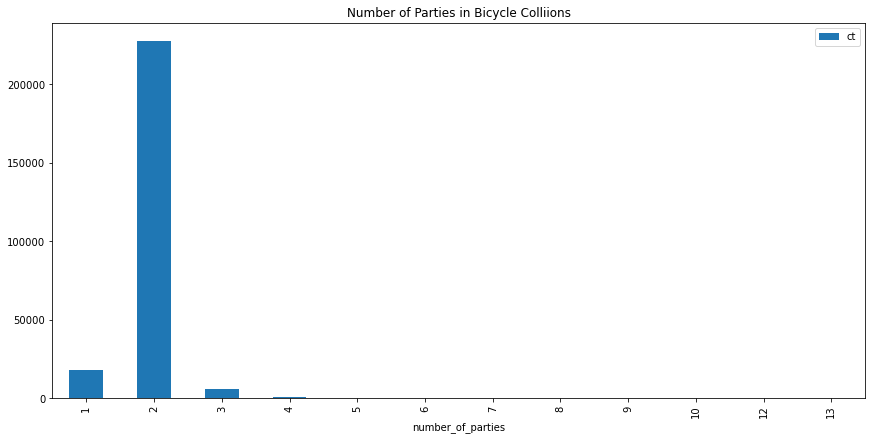

In [7]:
%%fsql
bicycle_parties = 
SELECT p.case_id, p.party_number 
FROM switrs.sqlite.parties AS p
INNER JOIN switrs.sqlite.collisions AS c
ON c.case_id = p.case_id
AND c.bicycle_collision ='1'
SELECT number_of_parties, COUNT(*) AS ct FROM (
    SELECT case_id, MAX(party_number) AS number_of_parties 
        FROM bicycle_parties 
        GROUP BY case_id
) GROUP BY number_of_parties
PRINT ROWS 100
OUTPUT USING PlotBar(x="number_of_parties", order_by=["number_of_parties"], title="Number of Parties in Bicycle Colliions")

* Majority of the bicycle collisions in California involved two parties.

#### References

Arancibia et al. (2019) [*Measuring the Local Economic Impacts of Replacing On-Street Parking With Bike Lanes.*](https://www.tandfonline.com/doi/abs/10.1080/01944363.2019.1638816?cookieSet=1)

Koch and Kraus (2020) [*Effect of pop-up bike lanes on cycling in European cities.*](https://arxiv.org/abs/2008.05883)

Urra (2020) [*Bike lanes: How cities across the world are responding to the pandemic*.](https://english.elpais.com/society/2020-11-06/bike-lanes-how-cities-across-the-world-are-responding-to-the-pandemic.html)

Deloitte (2020) [*Cycling's Technological Transformation: Making Bicycling faster, easier and safer*.](https://www2.deloitte.com/content/dam/insights/us/articles/722835_tmt-predictions-2020/DI_TMT-Prediction-2020.pdf)

Saad et al (2019) [*Bicycle Safety Analysis at Intersections from Crowdsourced Data*.](https://journals.sagepub.com/doi/abs/10.1177/0361198119836764)